In [54]:
import glob
import os
import csv
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

In [55]:
"""
Get latest file with filopodia lengths over time
"""
list_of_files = glob.glob('../filoLengthFiles/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

In [56]:
"""
Store file name and content
"""
fileName = latest_file.split('/')[2].replace(".txt", "")
f = open(latest_file, "r")
content = f.read()
f.close()

In [57]:
print(fileName)

filo_lengths_filvary_50.000000_epsilon_0.900000_VconcST0.040000_GRADIENT2_FILTIPMAX15.000000_tokenStrength1.000000_FILSPACING10_actinMax512.000000_randFilExtend-1.000000_randFilRetract-1.000000_run_1_


In [58]:
"""
CONSTANTS
"""
TIME_STEP = 15

In [59]:
"""
Get lengths recorded for each filopodium
"""
lengthsPerFilo = {}
# Get list of lengths for each filo
lines = content.split("\n")
for line in lines:
    if line != '': 
        elements = line.split(",")
        filo = elements[0]
        length = float(elements[1])
        if filo not in lengthsPerFilo: 
            lengthsPerFilo[filo] = []
        lengthsPerFilo[filo].append(length) 

# Quit this script if file is empty
if len(lengthsPerFilo) == 0:
    exit()

In [60]:
"""
Get lists of extension and retraction times
"""
timePerExtPerFilo = []
timePerRetPerFilo = []
extDuration = extendedLength = retDuration = retractedLength = 0

for filo, lengths in lengthsPerFilo.items(): 
    # Only parse this filo's lengths if it has retracted fully, i.e. last length is 0
    if lengths[-1] != 0:
        continue
    # Can't use len(filo) for some reason: "'float' object is not callable" error 
    prev = 0
    for length in lengths:
        diff = length - prev
        if diff > 0.05: # EXTENSION. Note: I look for >0.05 difference because the model tends to produce some 0.04xx difference numbers which wouldnt actually be recorded in real life as it's very small to the human eye
            extDuration += TIME_STEP
            extendedLength += diff
        elif diff < 0: # RETRACTION
            retDuration += TIME_STEP
            retractedLength += abs(diff)
        prev = length

    # For this filo, add seconds taken to extend each micron. Do the same for retraction.
    timePerExtPerFilo.append(extDuration / extendedLength)
    # DEBUGGING
    if extDuration / extendedLength > 65:
        print ("ext", filo, extDuration, extendedLength)
    if retractedLength > 0:
        timePerRetPerFilo.append(retDuration / retractedLength)
        # DEBUGGING
        if retDuration / retractedLength > 90:
            print ("ret", filo, retDuration, retractedLength)

    # Reset values for next filo
    extDuration = extendedLength = retDuration = retractedLength = 0

In [61]:
"""
Get KS statistic for extension and retraction times
"""
# Retrieve invivo data
extTimesIV = []
retTimesIV = []

with open('extTimesIV.csv', encoding='utf-8-sig') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for line in reader:
        for value in line:
            extTimesIV.append(value)

with open('retTimesIV.csv', encoding='utf-8-sig') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for line in reader:
        for value in line: 
            retTimesIV.append(value)

ksExt = stats.ks_2samp(timePerExtPerFilo, extTimesIV)
ksRet = stats.ks_2samp(timePerRetPerFilo, retTimesIV)
print(ksExt)
print(ksRet)

KstestResult(statistic=0.9125003461649142, pvalue=4.4523639091323935e-67)
KstestResult(statistic=0.9249598749712533, pvalue=2.783928421839729e-71)


In [62]:
print(max(extTimesIV))
print(max(retTimesIV))

60.729
85.02


In [63]:
""" 
Make style adjustments for plots
"""

sns.set(style="ticks", context="talk", font_scale=2)
plt.style.use("dark_background")
plt.figure(figsize=(500,500))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.rcParams.update({'font.size': 20})

<Figure size 36000x36000 with 0 Axes>

Text(0.5, 0, 'Time taken per micron extended (s)')

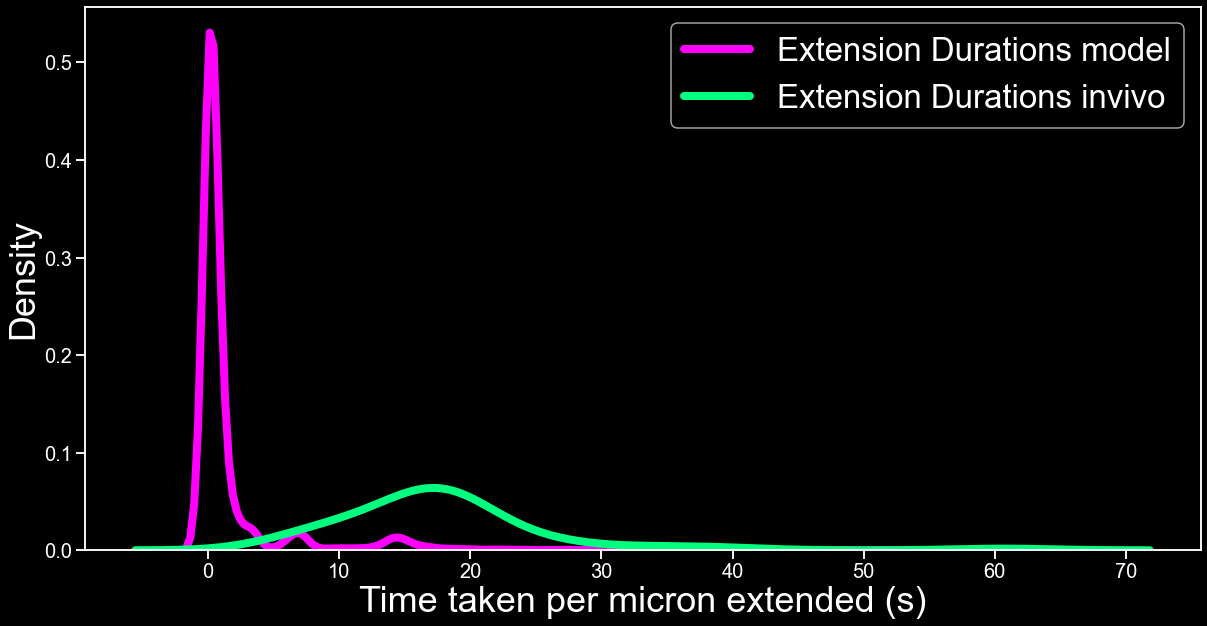

In [64]:
extPlot = plt.subplots(figsize=(20, 10))
extPlot = sns.kdeplot(timePerExtPerFilo, 
            color='magenta', 
            shade=False, 
            label='Extension Durations model',
            linewidth=8)
extPlot = sns.kdeplot(extTimesIV, 
            color='SpringGreen', 
            shade=False, 
            label='Extension Durations invivo',
            linewidth=8)
extPlot.legend()
plt.xlabel("Time taken per micron extended (s)")

Text(0.5, 0, 'Time taken per micron retracted (s)')

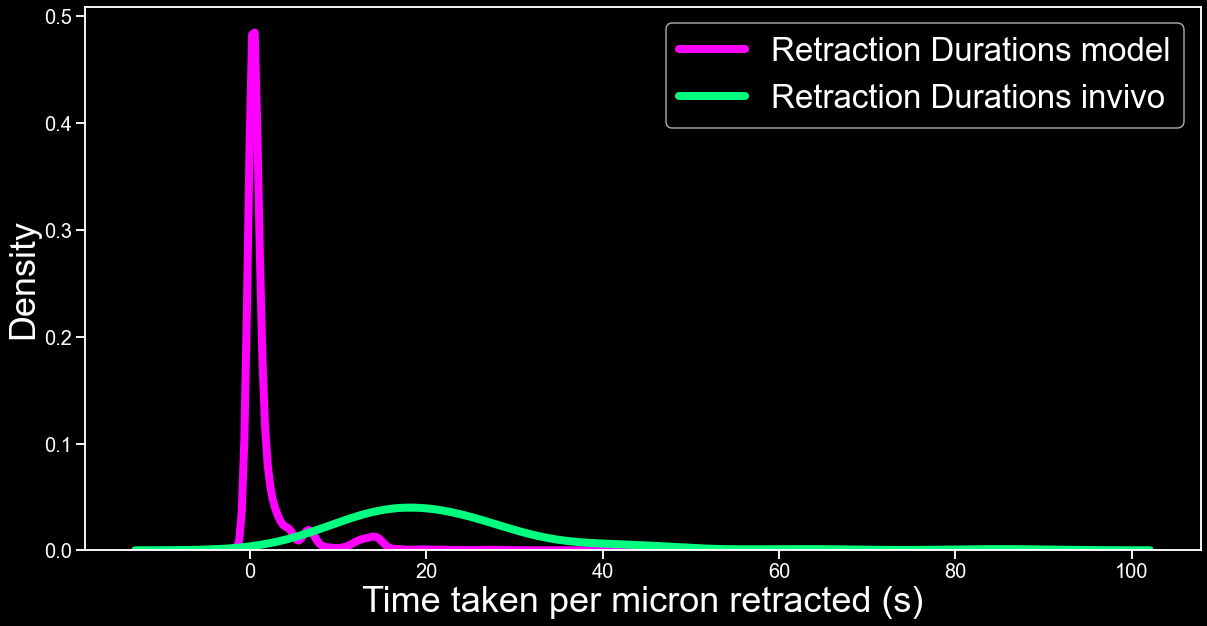

In [65]:
retPlot = plt.subplots(figsize=(20, 10))
retPlot = sns.kdeplot(timePerRetPerFilo, 
            color='magenta', 
            shade=False, 
            label='Retraction Durations model',
            linewidth=8)
retPlot = sns.kdeplot(retTimesIV, 
            color='SpringGreen', 
            shade=False, 
            label='Retraction Durations invivo',
            linewidth=8)
retPlot.legend()
plt.xlabel("Time taken per micron retracted (s)")